In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.pyplot import plot, draw, show
from scipy.linalg import lu
import scipy.linalg as la
import random
import simpy
import pandas as pd
import math
from IPython.display import display, HTML

In [105]:
# Init seed
RANDOM_SEED = 55
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Init service schemes
serviceScheme = "Long-Tailed"  # Can be "Long-Tailed", "Poisson", "Deterministic", "Inverse", "Random"
serviceSchemes = [
#     "Exponential",
    "Poisson",
    "Deterministic"  #, "Inverse", "Random", "Long-Tailed"
]

# Init simulation specific parameters
N_helpers = [1, 2, 4]  # Number of machines in the queue
SIM_TIME = 80  # Simulation time in minutes
NRUNS = 1  # Amount of runs
chanceLongTail = 0.75  # Chance of longtail lowerbound
lI = 8.0 / 5
lambdaIAT = [N * lI for N in N_helpers]  # Create a customer every ~lI minutes
# print(lambdaIAT)
cC = 200000
customerCount = [N * cC for N in N_helpers]  # Amount of customers
# print(customerCount)
rL = 1000
runLength = [N * rL for N in N_helpers]  # Amount of customer per average block
# print(runLength)

# Init servicetimes
serveT = 2
serviceTime = [serveT for N in N_helpers
               ]  # Minutes it takes to help a customer / Deterministic
ltLow = [10 for N in N_helpers]  # Lower bound long-tailed distribution
ltHigh = [50 for N in N_helpers]  # Upper bound long-tailed distribution
randspread = [1 for N in N_helpers]  # Spread of the random distribution
invMax = [45
          for N in N_helpers]  # max waiting time for the inverse servicetime
qServeInv = [[
    i for i in range(invMax[queueIndex], -1, -1)
    for x in range(math.ceil(customerCount[queueIndex] / invMax[queueIndex]))
] for queueIndex in range(len(N_helpers))]

# print(f"Rho Deterministic:\t {(lambdaIAT[0]) / (N * (1/serviceTime[0]))}")
# print(f"Rho Poisson/random:\t {(lambdaIAT[0]) / (N * (1/serviceTime[0]))}")
# print(f"Rho Inverse:\t {(lambdaIAT[0]) / (N * (1/np.mean(serviceTime)))}")
# print(f"Rho Long-Tailed:\t {(lambdaIAT[0]) / (N * (1/(0.75*ltL + 0.25*ltH)))}")

# Choose your queueing system
# resources = [simpy.PriorityResource]
# resources = [simpy.Resource]
# resources = [simpy.PriorityResource, simpy.Resource]


class Queue(object):
    def __init__(self, env, N, resource, helperIndex):
        self.env = env
        self.machine = resource(env, N)
        self.customerHelped = 0
        self.serverN = N
        self.helperIndex = helperIndex

    def helped(self, customer, customerServe):
        timestmp.append(self.env.now)
        yield self.env.timeout(customerServe)


def checkTest(now, entertime, customerHelped, runLength, customerLeft, cw):
    if customerLeft < runLength:
        return None
    if 0 < customerLeft % runLength <= 0.3 * runLength:
        pass
    elif 0.3 * runLength < customerLeft % runLength < runLength:
        tmpWait.append(now - entertime)
    return None


def customer(env, cw, resource, serviceScheme, runLength, cid):
    #     global customerLeft
    if serviceScheme == "Long-Tailed":
        rCheck = random.random()
        if rCheck <= 0.75:
            customerServeTime = np.random.poisson(ltLow[cw.helperIndex])
        else:
            customerServeTime = np.random.poisson(ltHigh[cw.helperIndex])
    elif serviceScheme == "Poisson":
        customerServeTime = np.random.poisson(
            1.0 / serviceTime[cw.helperIndex])
    elif serviceScheme == "Random":
        customerServeTime = random.uniform(
            serviceTime[cw.helperIndex] - randspread[cw.helperIndex],
            serviceTime[cw.helperIndex] + randspread[cw.helperIndex])
    elif serviceScheme == "Deterministic":
        customerServeTime = 1 / serviceTime[cw.helperIndex]
    elif serviceScheme == "Inverse":
        customerServeTime = qServeInv[cw.helperIndex][cw.customerHelped]
    elif serviceScheme == "Exponential":
        customerServeTime = random.expovariate(serviceTime[cw.helperIndex])

    customerServeTime = 0.000001 if customerServeTime == 0 else customerServeTime

    tmpRho.append(
        lambdaIAT[cw.helperIndex] / (cw.serverN * (1 / customerServeTime)))

    enterQueue = env.now
    if resource == simpy.PriorityResource:
        with cw.machine.request(priority=customerServeTime) as request:
            request.time = customerServeTime
            yield request
            cw.customerLeft += 1
            
            checkTest(env.now, enterQueue, cw.customerHelped,
                                  runLength, cw.customerLeft, cw)
            
            tmpServe.append(customerServeTime)
            yield env.process(cw.helped(cw.customerHelped, customerServeTime))

    elif resource == simpy.Resource:
        with cw.machine.request() as request:
            request.time = customerServeTime
            yield request
            cw.customerLeft += 1

            checkTest(env.now, enterQueue, cw.customerHelped,
                                  runLength, cw.customerLeft, cw)
            
            tmpServe.append(customerServeTime)
            yield env.process(cw.helped(cw.customerHelped, customerServeTime))


def setup(env, N, lambdaIAT, customerCount, resource, serviceScheme,
          helperIndex, runLength, customerLeft, subWaitingList):
    queue = Queue(env, N, resource, helperIndex)
    queue.customerLeft = customerLeft
    queue.subWaitingList = subWaitingList
    # Create more customers while the simulation is running
    s = np.random.poisson(1 / lambdaIAT, customerCount)
#     s = [1 / lambdaIAT for customer in range(customerCount)]
    cid = 0
    for i in range(4):
        cid += 1
        env.process(customer(env, queue, resource, serviceScheme, runLength, cid))
    while queue.customerHelped < customerCount:
        yield env.timeout(s[queue.customerHelped])
        queue.customerHelped += 1
        cid += 1
        env.process(customer(env, queue, resource, serviceScheme, runLength, cid))


columns = [
    "Rho", "Average", "Variance", "std_dev", "Resource", "Helpers", "run",
    "serviceScheme", "ServeMean"
]

resourceStatsRun = pd.DataFrame(columns=columns)
customerAll = pd.DataFrame(columns=columns)
for serviceScheme in serviceSchemes:
    for resource in resources:
        for helperIndex, N in enumerate(N_helpers):
            print(serviceScheme, str(resource)[33:-2], helperIndex)
            runServe = []
            runWait = []
            runRho = []
            times = []
            for j in range(NRUNS):

                timestmp = []
                random.seed(RANDOM_SEED)
                np.random.seed(RANDOM_SEED)
                subWaitingList = []
                customerLeft = 0
                tmpWait = []
                tmpServe = []
                tmpRho = []
                env = simpy.Environment()
                env.process(
                    setup(env, N, lambdaIAT[helperIndex],
                          customerCount[helperIndex], resource, serviceScheme,
                          helperIndex, runLength[helperIndex], customerLeft,
                          subWaitingList))
                env.run()
                
                resourceStatsRun.loc[serviceScheme + "_" + str(resource)[33:-2]
                                     + "_" + str(j) + "_" + str(N)] = [
                                         np.mean(tmpRho),
                                         np.mean(tmpWait),
                                         np.var(tmpWait),
                                         np.std(tmpWait),
                                         str(resource)[33:-2], N, j,
                                         serviceScheme,
                                         np.mean(tmpServe)
                                     ]

                runWait.append(tmpWait)
                runServe.append(tmpServe)
                runRho.append(tmpRho)
                times.append(timestmp[-1])
            
            np.array(runWait).flatten()
            np.array(runServe).flatten()
            np.array(runRho).flatten()
            dataK.append(runWait)
            #             print(runWait)
            customerAll.loc[serviceScheme + "_" + str(resource)[33:-2] + "_" +
                            str(N)] = [
                                np.mean(runRho),
                                np.mean(runWait),
                                np.var(runWait),
                                np.std(runWait),
                                str(resource)[33:-2], N, None, serviceScheme,
                                np.mean(runServe)
                            ]

Poisson PriorityResource 0
Poisson PriorityResource 1
Poisson PriorityResource 2


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [107]:
serviceScheme = "Deterministic"
resources = [simpy.PriorityResource, simpy.Resource]
resourceStatsRunDet = pd.DataFrame(columns=columns)
customerAllDet = pd.DataFrame(columns=columns)
for resource in resources:
    for helperIndex, N in enumerate(N_helpers):
        print(serviceScheme, str(resource)[33:-2], helperIndex)
        runServe = []
        runWait = []
        runRho = []
        times = []
        for j in range(NRUNS):

            timestmp = []
            random.seed(RANDOM_SEED)
            np.random.seed(RANDOM_SEED)
            subWaitingList = []
            customerLeft = 0
    #                 print(
    #                     f"Run {j} for {N} helpers for resource {str(resource)[33:-2]} and service {serviceScheme}."
    #                 )
            tmpWait = []
            tmpServe = []
            tmpRho = []
            env = simpy.Environment()
            env.process(
                setup(env, N, lambdaIAT[helperIndex],
                      customerCount[helperIndex], resource, serviceScheme,
                      helperIndex, runLength[helperIndex], customerLeft,
                      subWaitingList))
            env.run()

            resourceStatsRunDet.loc[serviceScheme + "_" + str(resource)[33:-2]
                                 + "_" + str(j) + "_" + str(N)] = [
                                     np.mean(tmpRho),
                                     np.mean(tmpWait),
                                     np.var(tmpWait),
                                     np.std(tmpWait),
                                     str(resource)[33:-2], N, j,
                                     serviceScheme,
                                     np.mean(tmpServe)
                                 ]

            runWait.append(tmpWait)
            runServe.append(tmpServe)
            runRho.append(tmpRho)
            times.append(timestmp[-1])

        np.array(runWait).flatten()
        np.array(runServe).flatten()
        np.array(runRho).flatten()
        dataK.append(runWait)
        #             print(runWait)
        customerAllDet.loc[serviceScheme + "_" + str(resource)[33:-2] + "_" +
                        str(N)] = [
                            np.mean(runRho),
                            np.mean(runWait),
                            np.var(runWait),
                            np.std(runWait),
                            str(resource)[33:-2], N, None, serviceScheme,
                            np.mean(runServe)
                        ]

KruskalResult(statistic=2.0, pvalue=0.36787944117144245)

,Unnamed: 0,weight,group
0,1,4.17,ctrl
1,2,5.58,ctrl
2,3,5.18,ctrl
3,4,6.11,ctrl
4,5,4.50,ctrl
5,6,4.61,ctrl
6,7,5.17,ctrl
7,8,4.53,ctrl
8,9,5.33,ctrl
9,10,5.14,ctrl


,Rho,Average,Variance,std_dev,Resource,Helpers,run,serviceScheme,ServeMean
Poisson_PriorityResource_1,0.800457,0.828663,3.570907,1.889684,PriorityResource,1,None,Poisson,0.500286
Poisson_PriorityResource_2,0.798497,0.380841,0.832484,0.912406,PriorityResource,2,None,Poisson,0.499061
Poisson_PriorityResource_4,0.798935,0.164684,0.177871,0.421747,PriorityResource,4,None,Poisson,0.499334
Deterministic_PriorityResource_1,0.800000,0.000000,0.000000,0.000000,PriorityResource,1,None,Deterministic,0.500000
Deterministic_PriorityResource_2,0.800000,0.000000,0.000000,0.000000,PriorityResource,2,None,Deterministic,0.500000
Deterministic_PriorityResource_4,0.800000,0.000000,0.000000,0.000000,PriorityResource,4,None,Deterministic,0.500000


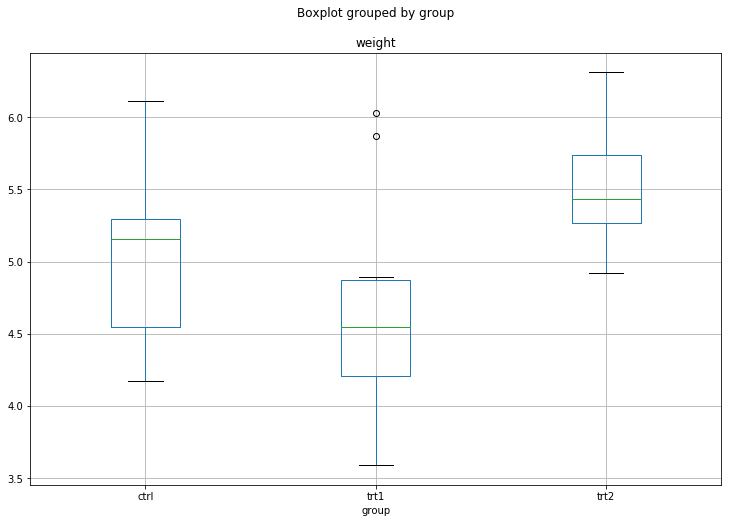

In [76]:
import pandas as pd
datafile = "PlantGrowth.csv"
data = pd.read_csv(datafile)
display(data)
display(customerAll)
#Create a boxplot
data.boxplot('weight', by='group', figsize=(12, 8))
 
ctrl = data['weight'][data.group == 'ctrl']
 
grps = pd.unique(data.group.values)
d_data = {grp:data['weight'][data.group == grp] for grp in grps}
 
k = len(pd.unique(data.group))  # number of conditions
N = len(data.values)  # conditions times participants
n = data.groupby('group').size()[0] #Participants in each condition

In [ ]:
grp = resourceStatsRun.groupby(["serviceScheme", "Resource", "Helpers"])
print(grp.Average.head())
printo = grp.Average.agg([np.mean, np.var, np.std])
print(printo)

# grpDescr = grp.describe()
# grpDescr
# display(HTML(grpDescr.ServeMean.to_html()))
# display(HTML(grpDescr.Average.to_html()))

In [118]:
import numpy as np, scipy.stats as st
a= resourceStatsRun.Average
st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))

(0.11672212101155821, 1.5250022804680556)

In [73]:
customerAll

,Rho,Average,Variance,std_dev,Resource,Helpers,run,serviceScheme,ServeMean
Poisson_PriorityResource_1,0.800457,0.828663,3.570907,1.889684,PriorityResource,1,None,Poisson,0.500286
Poisson_PriorityResource_2,0.798497,0.380841,0.832484,0.912406,PriorityResource,2,None,Poisson,0.499061
Poisson_PriorityResource_4,0.798935,0.164684,0.177871,0.421747,PriorityResource,4,None,Poisson,0.499334
Deterministic_PriorityResource_1,0.800000,0.000000,0.000000,0.000000,PriorityResource,1,None,Deterministic,0.500000
Deterministic_PriorityResource_2,0.800000,0.000000,0.000000,0.000000,PriorityResource,2,None,Deterministic,0.500000
Deterministic_PriorityResource_4,0.800000,0.000000,0.000000,0.000000,PriorityResource,4,None,Deterministic,0.500000


In [117]:
import math


def averageQueueTimesTwee(lamb, mu):
    rho = lamb / mu
    up = (rho**3)
    low = lamb * (1 - (rho**2))
    return up / low


def averageTimesTwee(lamb, mu):
    up = mu**2 + lamb**2
    low = mu * (mu**2 - lamb**2)
    return up / low


def averageCustomersTwee(lamb, mu):
    rho = lamb / mu
    up = rho * (mu**2 + lamb**2)
    low = mu**2 - lamb**2
    return up / low


def averageQueueCustomersTwee(lamb, mu):
    rho = lamb / mu
    up = 2 * rho**3
    low = 1 - rho**2
    return up / low


def C(rho, n):
    up = ((rho**n) / math.factorial(n)) * (n / (n - rho))
    low1 = 0
    for k in range(n):
        low1 += ((rho**k) / math.factorial(k))
    low2 = ((rho**n) * n) / (math.factorial(n) * (n - rho))
    low = low1 + low2
    return up / low


def ErlangC(A, N):
    L = (A**N / math.factorial(N)) * (N / (N - A))
    sum_ = 0
    for i in range(N):
        sum_ += (A**i) / math.factorial(i)
    return (L / (sum_ + L))


def Wq(rho, mu, n):
    Pq = C(rho, n)
    a = 1 / (mu * (n - rho))
    return a * Pq


def averageQueueTimesOne(lamb, mu):
    rho = lamb / mu
    up = rho
    low = mu * (1 - rho)
    return up / low


print("For 1 servers")
print(f"Average time in queue calculated = {averageQueueTimesOne(l, u)}")

n = 1
l = 8.0 / 5
u = 2.0
rho = l / u

variant1 = {Wq(1 * rho, u, n)}
variant2 = {Wq(2 * rho, u, n)}
variant4 = {Wq(4 * rho, u, n)}

v1SampleSize = np.sqrt()

True
For 2 servers using variant of M/M/2
Average time in queue calculated = 0.8888888888888893

For 1 servers
Average time in queue calculated = 2.0000000000000004

For n=1
C(rho, 2) = 0.8
Wq = 2.0000000000000004
Wq variant = 2.0000000000000004

For n=2
C(rho, 2) = 0.2285714285714286
Wq = 0.09523809523809525
Wq variant = 0.888888888888889

For n=3
C(rho, 2) = 0.052032520325203266
Wq = 0.01182557280118256
Wq variant = 0.5393258426966296

For n=4
C(rho, 2) = 0.009580838323353297
Wq = 0.0014970059880239526
Wq variant = 0.3727702948671279


In [ ]:
%matplotlib inline
grp = resourceStatsRun.groupby(["serviceScheme", "Resource", "Helpers"])
display(HTML(grp.Average.agg([np.mean, np.var, np.std]).to_html()))

# grpDescr = grp.describe()
# grpDescr
# # display(HTML(grpDescr.ServeMean.to_html()))
# # display(HTML(grpDescr.Average.to_html()))

# fig, ax = plt.subplots(figsize=(8,6))
# grp.Average.agg([np.mean]).plot(kind='barh', ax=ax)

In [ ]:
lijstpoisson = []
lijstexpo = []

for i in range(1000):
    po = random.expovariate(2)
    pa = np.random.poisson(8/5)
    print(po)
    lijstpoisson.append(po)
    lijstexpo.append(pa)
print(np.mean(lijstpoisson))
print(np.mean(lijstexpo))